In [12]:
import os
import json
import csv
import pandas as pd
import numpy as np
import torchaudio
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [13]:
# load train df from train csv
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')

test_df.head()


,utterance,utt,spn,o_utt,item,o_item,alc,sex,age,acc,...,irreg,anncom,specom,type,content,file_path,duration,alc_mapped,resampled_path,spectrogram_filepath
0,0401041004_h_00,401041004,40,NaN,4,NaN,a,F,27,BY,...,0|0|0|0|0|0|0|0|0,NaN,NaN,R,A,ALC/ses1041/0401041004_h_00.wav,6.25,Intoxicated,resampled_audio/0401041004_h_00.wav,spectrograms/0401041004_h_00.npy
1,0401041020_h_00,401041020,40,402034020.0,20,20.0,a,F,27,BY,...,1|0|1|0|0|1|0|0|0,NaN,NaN,R,T,ALC/ses1041/0401041020_h_00.wav,7.25,Intoxicated,resampled_audio/0401041020_h_00.wav,spectrograms/0401041020_h_00.npy
2,0401041012_h_00,401041012,40,402034012.0,12,12.0,a,F,27,BY,...,0|0|2|0|0|0|0|0|0,NaN,NaN,L,T,ALC/ses1041/0401041012_h_00.wav,11.51,Intoxicated,resampled_audio/0401041012_h_00.wav,spectrograms/0401041012_h_00.npy
3,0401041028_h_00,401041028,40,402034049.0,28,49.0,a,F,27,BY,...,9999|0|2|1|0|0|0|0|0,NaN,NaN,E,C,ALC/ses1041/0401041028_h_00.wav,9.75,Intoxicated,resampled_audio/0401041028_h_00.wav,spectrograms/0401041028_h_00.npy
4,0401041015_h_00,401041015,40,402034015.0,15,15.0,a,F,27,BY,...,9999|0|0|0|0|0|0|0|0,NaN,NaN,L,N,ALC/ses1041/0401041015_h_00.wav,5.53,Intoxicated,resampled_audio/0401041015_h_00.wav,spectrograms/0401041015_h_00.npy


In [14]:
def resample_and_save_audio(file_path, new_sample_rate=16000, save_dir='resampled_audio'):
    # Load the audio file
    waveform, sample_rate = torchaudio.load(file_path)

    # Resample
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
    resampled_waveform = resampler(waveform)

    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Construct new file path
    base_filename = os.path.basename(file_path)
    new_file_path = os.path.join(save_dir, base_filename)

    # Save the resampled audio
    torchaudio.save(new_file_path, resampled_waveform, new_sample_rate)

    return new_file_path


In [15]:
new_file_paths = []

for index, row in train_df.iterrows():
    original_file_path = row['file_path']
    fp = os.path.abspath(f"../{original_file_path}")
    new_file_path = resample_and_save_audio(fp)
    new_file_paths.append(new_file_path)

# Add the new file paths to your DataFrame
train_df['resampled_path'] = new_file_paths

# Save the DataFrame as a CSV file
train_df.to_csv('../train.csv', index=False)


In [16]:
new_file_paths = []

for index, row in test_df.iterrows():
    original_file_path = row['file_path']
    fp = os.path.abspath(f"../{original_file_path}")
    new_file_path = resample_and_save_audio(fp)
    new_file_paths.append(new_file_path)

# Add the new file paths to your DataFrame
test_df['resampled_path'] = new_file_paths

# Save the DataFrame as a CSV file
test_df.to_csv('../test.csv', index=False)


In [14]:
def process_and_save_spectrogram(file_path, sample_rate=16000, save_dir='spectrograms'):
    # Load the audio file
    waveform, original_sample_rate = torchaudio.load(f"../{file_path}")

    if original_sample_rate != sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=original_sample_rate, new_freq=sample_rate)
        waveform = resampler(waveform)

    # Create save directory if it doesn't exist
    if not os.path.exists(f"../{save_dir}"):
        os.makedirs(f"../{save_dir}")

    spectrogram_transform = torchaudio.transforms.Spectrogram(n_fft=400, win_length=None, hop_length=None, power=2)
    spectrogram = spectrogram_transform(waveform)

    spectrogram = spectrogram.numpy()

    # save as np array
    filename = f"{save_dir}/{os.path.splitext(os.path.basename(file_path))[0]}.npy"
    np.save(f"../{filename}", spectrogram)

    return filename


In [19]:
filepaths = train_df['resampled_path'].tolist()

spectrogram_filepaths = []

for filepath in filepaths:
    spectrogram_filepath = process_and_save_spectrogram(filepath)
    spectrogram_filepaths.append(spectrogram_filepath)

print(len(spectrogram_filepaths))

train_df['spectrogram_filepath'] = spectrogram_filepaths

train_df.to_csv('../train.csv', index=False)


12030


(1, 201, 741)


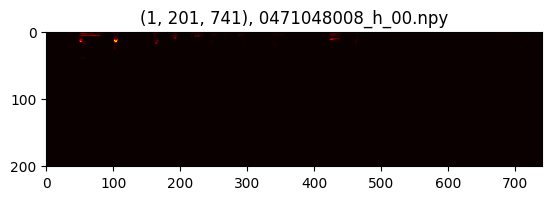

(1, 201, 361)


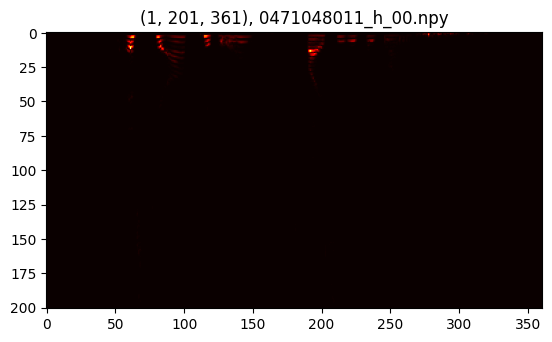

(1, 201, 180)


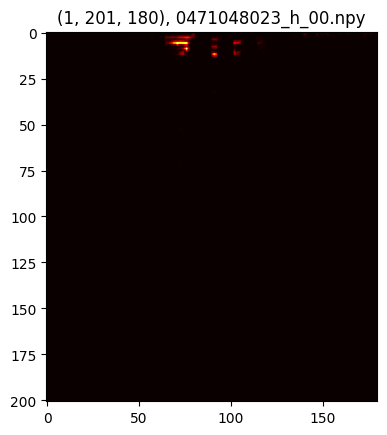

(1, 201, 881)


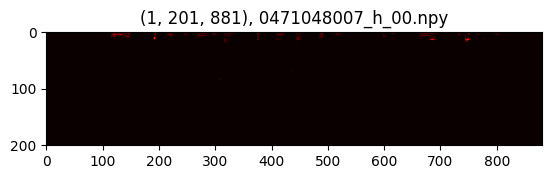

(1, 201, 281)


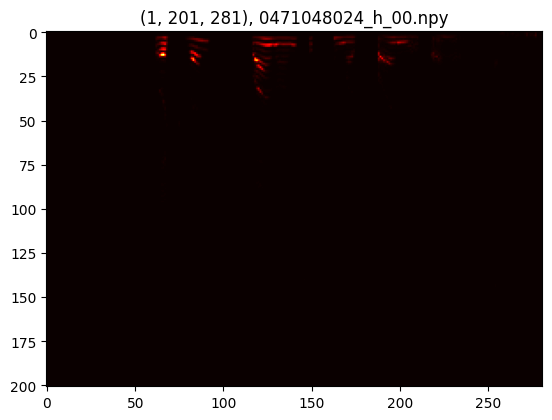

In [20]:
for filepath in spectrogram_filepaths[:5]:
    spectrogram = np.load(f"../{filepath}")
    print(spectrogram.shape)
    plt.figure()
    plt.imshow(spectrogram[0, :, :], cmap='hot')
    plt.title(f"{spectrogram.shape}, {os.path.basename(filepath)}")
    plt.show()
